In [ ]:
def Verify(expression: bool, message: str):
    if not expression:
        raise Exception(message)
    else:
        return

<h1>Task 1.1: IMDB Data loading</h1>

In [ ]:
import numpy as np

class IMDBSample:
    def __init__(self, rowIndex, numberOfFeatures=89527):
        self.rowIndex = rowIndex
        self.features = np.zeros(numberOfFeatures)
        self.label = -1

class IMDBDataLoader:
    def __init__(self, vocabFilepath, featFilepath):
        self.samples = []
        self.words = []
        self.vocabFilepath = vocabFilepath
        self.featFilepath = featFilepath
        self.ParseIntoVectors()
    
    def ParseIntoVectors(self):
        with open(self.featFilepath, 'r', encoding='utf-8') as file:
            for line_number, line in enumerate(file, start=0):
                currentSample = IMDBSample(line_number)
                parts = line.split()
                Verify(int(parts[0])>6 or int(parts[0]) < 6, "Error: Rating value unexpected in IMDB dataloader.")
                currentSample.label = int(int(parts[0]))
                for part in parts[1:]:
                    wordIndex, frequency = map(int, part.split(':'))
                    Verify(wordIndex<currentSample.features.size, "Word index larger than number of features in IMDB dataloader")
                    Verify(frequency>=0, "Word Frequency is smaller than expected in IMDB dataloader.")
                    currentSample.features[wordIndex] = frequency
                self.samples.append(currentSample)

        with open(self.vocabFilepath, 'r', encoding='utf-8') as file:
            for line_number, line in enumerate(file, start = 0):
                self.words.append(line)
                
    
    def GetData(self):
        numberOfSamples = len(self.samples)
        numberOfFeatures = self.samples[0].features.size if self.samples else 0

        X = np.zeros((numberOfSamples, numberOfFeatures))
        y = np.zeros(numberOfSamples)

        for i, sample in enumerate(self.samples):
            X[i,:] = sample.features
            y[i] = sample.label
        return y, X
    
    def GetWords(self):
        return self.words

<h3>Data loading</h3>

In [ ]:
vocabFilepath = '../aclImdb/imdb.vocab'
trainfeatFilepath = '../aclImdb/train/labeledBow.feat'
testfeatFilepath = '../aclImdb/test/labeledBow.feat'
dataloaderTrain = IMDBDataLoader(vocabFilepath, trainfeatFilepath)
dataloaderTest = IMDBDataLoader(vocabFilepath, testfeatFilepath)
print("Dataloading complete")
y_train, X_train = dataloaderTrain.GetData()
y_test, X_test = dataloaderTest.GetData()

words = dataloaderTrain.GetWords()


<h3>Data filtering</h3>

In [ ]:
onePercentThreshold = int(y_train.size*0.01)
fiftyPercentThreshold = int(y_train.size*0.5)
featureFrequencies = np.sum(X_train > 0, axis=0)

featuresToKeep = (featureFrequencies > onePercentThreshold) & (featureFrequencies < fiftyPercentThreshold)
featureFrequenciesFiltered = featureFrequencies[featuresToKeep]
XFiltered_train = X_train[:, featuresToKeep]
XFiltered_test = X_test[:, featuresToKeep]
wordsFiltered = [word for word, keep in zip(words, featuresToKeep) if keep]

weights = np.linalg.inv(XFiltered_train.T @ XFiltered_train) @ XFiltered_train.T @ y_train #OLS SSE Solution
D_Selected = 1000
feature_importances = np.abs(np.copy(weights))
top_features_indices = np.argsort(feature_importances)[-D_Selected:]
XFiltered_train_selected = XFiltered_train[:, top_features_indices]
XFiltered_test_selected = XFiltered_test[:, top_features_indices]
featureFrequenciesFiltered_Selected = featureFrequenciesFiltered[top_features_indices]
wordsFiltered_selected = [wordsFiltered[i] for i in top_features_indices]

<h3>Displaying Top Words (Task 3.1)</h3>

In [ ]:
numberOfWordsToDisplay = 10 #both positive and negative side
positive_weights_indices = np.argsort(weights)[-numberOfWordsToDisplay:]
negative_weights_indices = np.argsort(weights)[:numberOfWordsToDisplay]
words_with_largest_positive_weights = [(wordsFiltered[i].strip(), weights[i], featureFrequenciesFiltered[i]) for i in positive_weights_indices]
words_with_largest_negative_weights = [(wordsFiltered[i].strip(), weights[i], featureFrequenciesFiltered[i]) for i in negative_weights_indices]

print(f"Words with the {numberOfWordsToDisplay} largest positive weights:")
for word, weight, frequency in reversed(words_with_largest_positive_weights):
    print(f"Word: '{word}', Weight: {weight:.5f}, Frequency: {frequency}")

print("\n")

print(f"Words with the {numberOfWordsToDisplay} largest negative weights:")
for word, weight, frequency in words_with_largest_negative_weights:
    print(f"Word: '{word}', Weight: {weight:.5f}, Frequency: {frequency}")

<h1>Task 2.1 Logistic Regression</h1>

Iteration1 	 Cost: 501155.9381533897
Iteration2 	 Cost: 462565.0549970848
Iteration3 	 Cost: 423975.45242802554
Iteration4 	 Cost: 385388.5412719979
Iteration5 	 Cost: 346808.79812753876
Iteration6 	 Cost: 308253.7086574228
Iteration7 	 Cost: 269798.54146395955
Iteration8 	 Cost: 231766.12643205674
Iteration9 	 Cost: 194956.51332576407
Iteration10 	 Cost: 160974.7787458001
Iteration11 	 Cost: 131955.20845408516
Iteration12 	 Cost: 109473.31027592793
Iteration13 	 Cost: 93526.19475537448
Iteration14 	 Cost: 82960.97230416251
Iteration15 	 Cost: 76244.70610589394
Iteration16 	 Cost: 71809.55746038687
Iteration17 	 Cost: 68711.2881867778
Iteration18 	 Cost: 66404.34835855049
Iteration19 	 Cost: 64577.19550654279
Iteration20 	 Cost: 63042.816614461684
Iteration21 	 Cost: 61684.463219847145
Iteration22 	 Cost: 60437.92260954924
Iteration23 	 Cost: 59267.39224809724
Iteration24 	 Cost: 58153.59548959449
Iteration25 	 Cost: 57086.25531573904
Iteration26 	 Cost: 56059.6281745603
Iteration27 	 

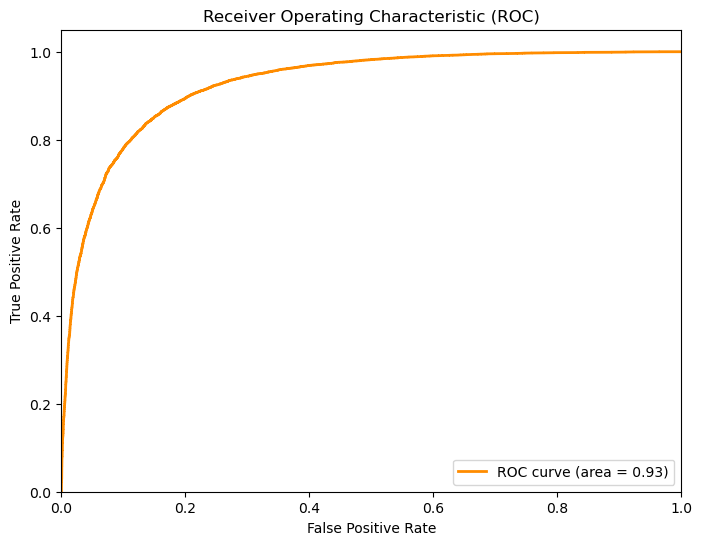

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class CE_Loss:
    def set_data(self, y_true, X):
        self.y_true = y_true
        self.X = X
    
    def __call__(self, w):
        a = self.X@w
        # y_pred = 1/(1+np.exp(-a))
        # return -np.mean(self.y_true*np.log(y_pred)-(1-self.y_true)*np.log(1-y_pred))
        ###Equivalently for precision and numerical stability (slide 9/37 logistic regression)###
        return np.sum(self.y_true*np.log1p(np.exp(-a)) +(1-self.y_true)*np.log1p(np.exp(a)))
    
    def grad(self, w):
        a = self.X@w
        y_pred = 1/(1+np.exp(-a))
        return self.X.T@(y_pred-self.y_true)/self.y_true.size
        
#minimizes
class Gradient_Descent:
    def __init__(self, weights, learning_rate, max_iter, epsilon, cost_function):
        self.weights = weights
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.cost_acc = []
        self.epsilon = epsilon
        self.f = cost_function

    def optimize(self):
        initial_cost = self.f(self.weights)
        self.cost_acc.append(initial_cost)

        for i in range(self.max_iter):
            self.weights -= self.f.grad(self.weights)
            new_cost = self.f(self.weights)
            print(f"Iteration{i+1} \t Cost: {new_cost}") #Toggle
            self.cost_acc.append(new_cost)
            delta = new_cost-self.cost_acc[i]
            if (np.abs(delta)<self.epsilon):
                return new_cost
        return new_cost
            

class Binary_Logitstic_Regression:
    def __init__(self, learning_rate = 0.1, max_iter=1000, epsilon=1e-6, cost_function=CE_Loss()):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.f = cost_function

    def fit(self, X, y):
        self.X = X
        self.y = (y>5).astype(int) #Turn to binary immediately
        self.weights = np.ones(X.shape[1])
        self.f.set_data(self.y, self.X)
        optimizer = Gradient_Descent(self.weights, self.learning_rate, self.max_iter, self.epsilon, self.f)
        optimizer.optimize()
    
    def predict(self, X):
        Verify(self.weights.shape[0]>0, "Weights not optimized yet")
        return 1/(1+np.exp(-X@self.weights))
    
def perform_roc_and_auroc(predicted_probabilities, true_binary_labels):
    if predicted_probabilities.shape != true_binary_labels.shape:
        raise ValueError("Shapes of predicted probabilities and true labels must match.")
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(true_binary_labels, predicted_probabilities)
    
    # Calculate the AUROC
    auroc = auc(fpr, tpr)
    roc_curve_data = (fpr, tpr, thresholds)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    return auroc, roc_curve_data

    

regressionObject = Binary_Logitstic_Regression()
regressionObject.fit(XFiltered_train_selected, y_train)
test_output = regressionObject.predict(XFiltered_test_selected)
auroc, roc_curve_data = perform_roc_and_auroc(test_output, (y_test>5).astype(int))

    





        

